## Notebook setup

In [1]:
import os
import io
import warnings
import datetime
import numpy as np
import base64

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from IPython.display import HTML

# import sys
# sys.path.append('../../')

from openbb_terminal.reports import widget_helpers as widgets
from openbb_terminal.sdk import openbb
from openbb_terminal.helper_classes import TerminalStyle
from openbb_terminal.core.config.paths import REPOSITORY_DIRECTORY

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

# Detect if prediction capabilities are present. If they are not, disable prediction in the rest of the script
# so that the report can still be generated without prediction results.
# predictions = True
# try:
#     openbb.stocks.pred.models
# except Exception as e:
#     predictions = False

# TODO Fix predictions virtual path on api refactored

predictions = False

In [2]:
try:
    theme = TerminalStyle("light", "light", "light")
except:
    pass
stylesheet = widgets.html_report_stylesheet()

## Select Ticker

In [3]:
# Parameters that will be replaced when calling this notebook
# Do not leave parameters blank as notebook will not run otherwise
symbol = "VTI"
report_name = "Equity Report for VTI"

In [4]:
# Parameters
symbol = "qqq"
report_name = "C:\\Users\\taylo\\OpenBBUserData\\reports\\20221211_235214_etf_qqq"


In [5]:
ticker = symbol

In [6]:
if "." in ticker:
    import sys

    sys.exit(0)

In [7]:
ticker_data = openbb.stocks.load(
    symbol=ticker, start_date=datetime.datetime.now() - datetime.timedelta(days=4 * 30)
)
ticker_data = openbb.stocks.process_candle(data=ticker_data)

author = "OpenBB"
report_title = f"ETF RESEARCH REPORT ON {ticker.upper()}"
report_date = datetime.datetime.now().strftime("%d %B, %Y")
report_time = datetime.datetime.now().strftime("%H:%M")
report_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo
report_title, report_date, report_time, report_timezone

Loading Daily data for QQQ with starting period 2022-08-15.

('ETF RESEARCH REPORT ON QQQ',
 '11 December, 2022',
 '23:52',
 datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'Eastern Standard Time'))

In [8]:
info = openbb.etf.summary(name=ticker)
info

'To maintain the correspondence between the composition and weights of the securities in the trust (the "securities") and the stocks in the NASDAQ-100 Index®, the adviser adjusts the securities from time to time to conform to periodic changes in the identity and/or relative weights of index securities. The composition and weighting of the securities portion of a portfolio deposit are also adjusted to conform to changes in the index.'

## Data

Loading Daily data for QQQ with starting period 2019-12-09.

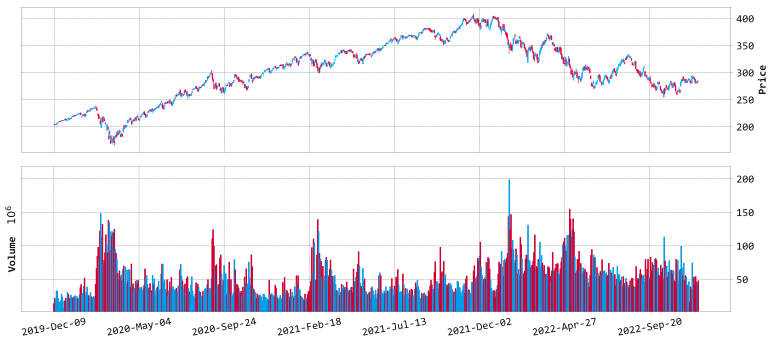

In [9]:
data = openbb.stocks.load(ticker)

fig, (candles, volume) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.etf.candle(
    symbol=ticker,
    data=data,
    use_matplotlib=True,
    external_axes=[candles, volume],
)

candles.set_xticklabels("")
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
candle_chart = f.getvalue().decode("utf-8")

In [10]:
import pandas as pd

weights = openbb.etf.weights(ticker)
weights_df = pd.DataFrame.from_dict([weights]).T
weights_df.columns = ["Percentage"]

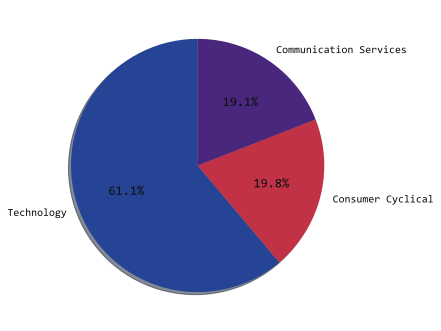

In [11]:
fig, ax = plt.subplots(dpi=150)
ax.pie(
    weights_df[weights_df["Percentage"] > 10]["Percentage"],
    labels=weights_df[weights_df["Percentage"] > 10].index,
    autopct="%1.1f%%",
    shadow=True,
    startangle=90,
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
weights_chart = f.getvalue().decode("utf-8")

In [12]:
holdings = openbb.etf.holdings(ticker)
holdings

,Name,% Of Etf,Shares
Symbol,,,
AAPL,Apple Inc.,12.94%,142048009
MSFT,Microsoft Corporation,10.37%,65919753
AMZN,"Amazon.com, Inc.",5.14%,90046893
NVDA,NVIDIA Corporation,3.38%,30973670
GOOG,"Alphabet, Inc.",3.25%,54474240
...,...,...,...
LCID,"Lucid Group, Inc.",0.14%,24604348
SPLK,Splunk Inc.,0.13%,2385976
MTCH,"Match Group, Inc.",0.12%,4149992


## Render the report template to a file

In [13]:
body = ""

img = (
    str(REPOSITORY_DIRECTORY)
    + "/openbb_terminal/reports/templates/OpenBB_reports_logo.png"
)
floppy_disk_img = (
    str(REPOSITORY_DIRECTORY) + "/openbb_terminal/reports/templates/floppy-disc.png"
)
body += widgets.header(
    img,
    floppy_disk_img,
    author,
    report_date,
    report_time,
    report_timezone,
    f"<b>ETF RESEARCH REPORT:</b> {ticker.upper()}",
)

body += widgets.tablinks(["SUMMARY"])

htmlcode = widgets.h(3, "Summary")
htmlcode += widgets.p(info)
htmlcode += widgets.row([candle_chart])

htmlcode += widgets.p("The ETF has the following weights distribution:")

htmlcode += widgets.row([weights_df.to_html()])

htmlcode += widgets.p("And has funds in the following assets:")
htmlcode += widgets.row([holdings.to_html()])

body += widgets.add_tab("SUMMARY", htmlcode)

body += widgets.tab_clickable_and_save_evt()

report = widgets.html_report(title=report_name, stylesheet=stylesheet, body=body)

# to save the results
with open(report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)